# ThoughtLink — Data Exploration

Exploratory analysis of the KernelCo/robot_control BCI dataset.

- **Source**: HuggingFace `KernelCo/robot_control`
- **Format**: `.npz` files, 15-second chunks
- **EEG**: 6 channels (AFF6, AFp2, AFp1, AFF5, FCz, CPz), 500 Hz
- **Classes**: Right Fist, Left Fist, Both Fists, Tongue Tapping, Relax

In [1]:
import sys
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, str(Path('.').resolve().parent / 'src'))
from thoughtlink.data.loader import load_all, CLASS_NAMES, EEG_CHANNELS, EEG_SFREQ

sns.set_theme(style='whitegrid', font_scale=1.1)

samples = load_all()
print(f'Total samples: {len(samples)}')

Fetching 903 files:   0%|          | 0/903 [00:00<?, ?it/s]

Loaded 900 samples from /Users/david.camachob/Documents/thoughtlink/notebooks/data/raw
Classes: ['Both Fists', 'Left Fist', 'Relax', 'Right Fist', 'Tongue Tapping']
Subjects: 6
Total samples: 900


## 1. Class Distribution

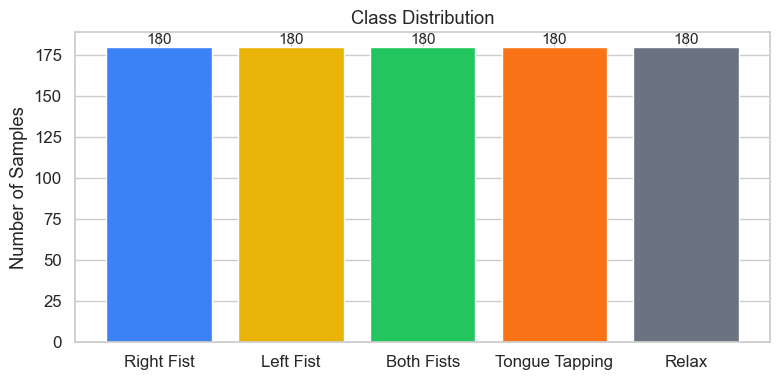

Total: 900 samples across 6 subjects


In [2]:
label_counts = Counter(s['label'] for s in samples)

fig, ax = plt.subplots(figsize=(8, 4))
colors = ['#3b82f6', '#eab308', '#22c55e', '#f97316', '#6b7280']
names = CLASS_NAMES
counts = [label_counts.get(n, 0) for n in names]

bars = ax.bar(names, counts, color=colors, edgecolor='white')
for bar, c in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            str(c), ha='center', fontsize=11)

ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution')
fig.tight_layout()
plt.show()

print(f'Total: {sum(counts)} samples across {len(set(s["subject_id"] for s in samples))} subjects')

## 2. Subject Distribution

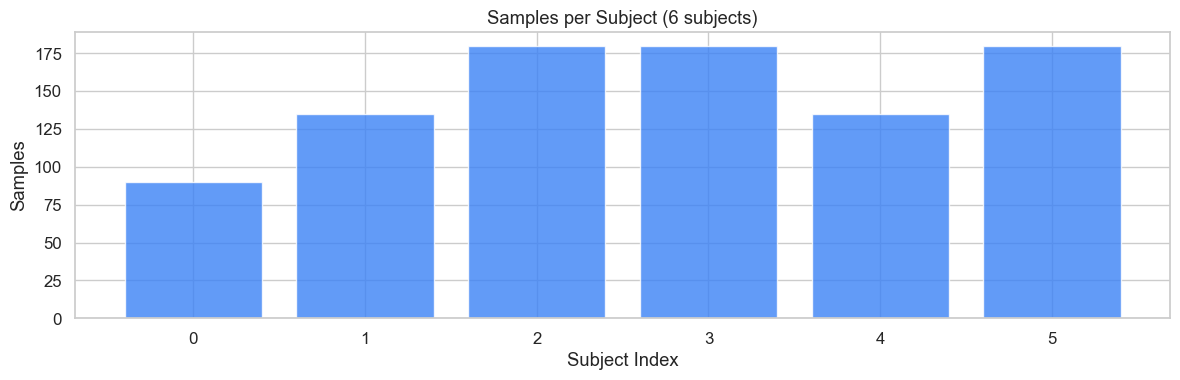

Samples per subject: min=90, max=180, mean=150.0


In [3]:
subject_counts = Counter(s['subject_id'] for s in samples)

fig, ax = plt.subplots(figsize=(12, 4))
subjects = sorted(subject_counts.keys())
counts = [subject_counts[s] for s in subjects]
ax.bar(range(len(subjects)), counts, color='#3b82f6', alpha=0.8)
ax.set_xlabel('Subject Index')
ax.set_ylabel('Samples')
ax.set_title(f'Samples per Subject ({len(subjects)} subjects)')
fig.tight_layout()
plt.show()

print(f'Samples per subject: min={min(counts)}, max={max(counts)}, mean={np.mean(counts):.1f}')

## 3. Raw EEG Traces (One Sample per Class)

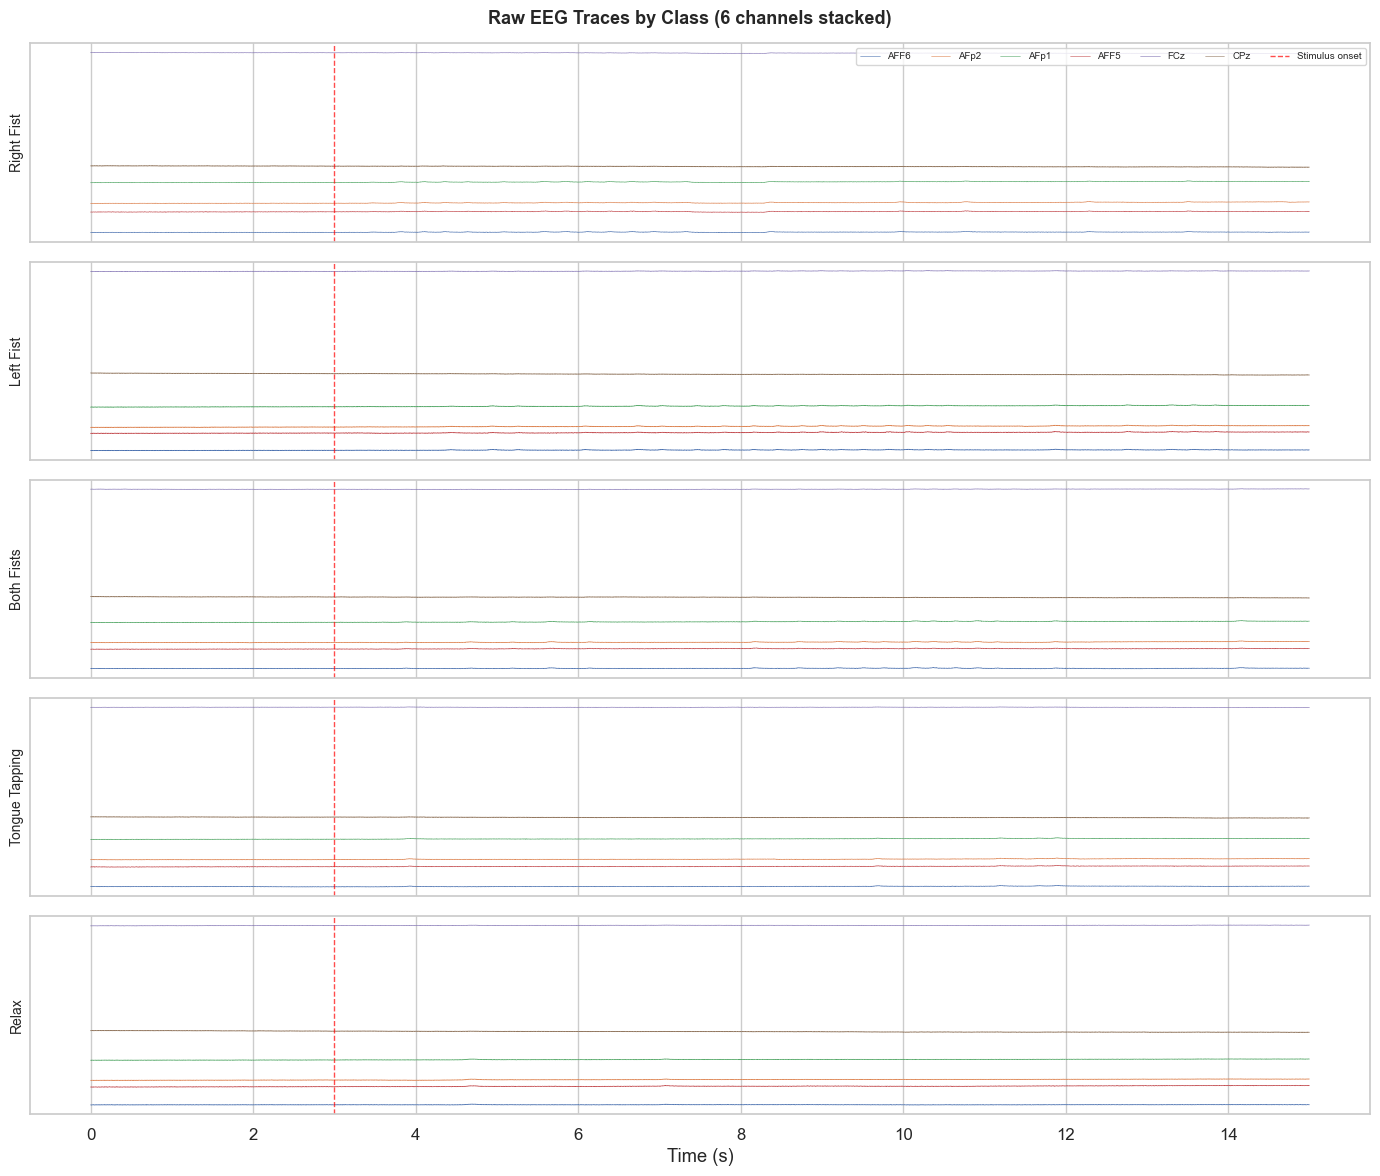

In [4]:
fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

for idx, class_name in enumerate(CLASS_NAMES):
    sample = next(s for s in samples if s['label'] == class_name)
    eeg = sample['eeg']  # (7499, 6)
    t = np.arange(eeg.shape[0]) / EEG_SFREQ

    ax = axes[idx]
    for ch in range(6):
        ax.plot(t, eeg[:, ch] + ch * 40, lw=0.4, label=EEG_CHANNELS[ch])
    ax.axvline(3.0, color='red', ls='--', lw=1, alpha=0.7, label='Stimulus onset')
    ax.set_ylabel(class_name, fontsize=10)
    ax.set_yticks([])
    if idx == 0:
        ax.legend(fontsize=7, loc='upper right', ncol=7)

axes[-1].set_xlabel('Time (s)')
fig.suptitle('Raw EEG Traces by Class (6 channels stacked)', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.show()

## 4. Power Spectral Density per Class

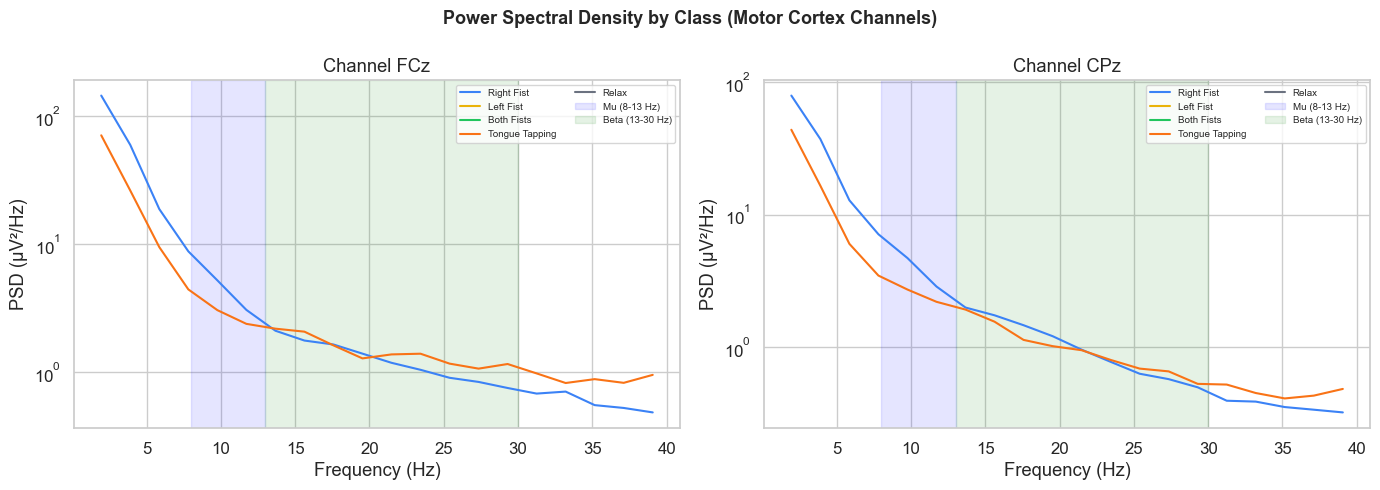

In [5]:
from scipy.signal import welch

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#3b82f6', '#eab308', '#22c55e', '#f97316', '#6b7280']

# Compute average PSD per class for FCz (channel 4) and CPz (channel 5) - motor cortex
for ch_idx, ch_name in [(4, 'FCz'), (5, 'CPz')]:
    ax = axes[0 if ch_idx == 4 else 1]
    for cls_idx, cls_name in enumerate(CLASS_NAMES):
        cls_samples = [s for s in samples if s['label'] == cls_name][:20]
        psds = []
        for s in cls_samples:
            stim_start = int(3.0 * EEG_SFREQ)
            stim_end = min(stim_start + int(4.0 * EEG_SFREQ), s['eeg'].shape[0])
            segment = s['eeg'][stim_start:stim_end, ch_idx]
            freqs, psd = welch(segment, fs=EEG_SFREQ, nperseg=256)
            psds.append(psd)
        mean_psd = np.mean(psds, axis=0)
        ax.semilogy(freqs[(freqs >= 1) & (freqs <= 40)],
                    mean_psd[(freqs >= 1) & (freqs <= 40)],
                    label=cls_name, color=colors[cls_idx], lw=1.5)

    # Mark mu and beta bands
    ax.axvspan(8, 13, alpha=0.1, color='blue', label='Mu (8-13 Hz)')
    ax.axvspan(13, 30, alpha=0.1, color='green', label='Beta (13-30 Hz)')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (\u00b5V\u00b2/Hz)')
    ax.set_title(f'Channel {ch_name}')
    ax.legend(fontsize=7, ncol=2)

fig.suptitle('Power Spectral Density by Class (Motor Cortex Channels)', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.show()

## 5. Summary

| Property | Value |
|----------|-------|
| **Total samples** | ~900 |
| **Subjects** | See above |
| **EEG channels** | 6 (AFF6, AFp2, AFp1, AFF5, FCz, CPz) |
| **Sampling rate** | 500 Hz |
| **Chunk duration** | 15 seconds |
| **Stimulus onset** | 3.0 seconds |
| **Key bands** | Mu (8-13 Hz): motor imagery ERD. Beta (13-30 Hz): motor planning |
| **Motor cortex** | FCz, CPz channels most relevant for motor imagery decoding |